In [1]:
from pathlib import Path
import os
import json

from models.prob_decoders import *
from models.embeddings import *
from models.hist_encoders import *
from datasets.tpp_loader import *
from models.tpp_warper import TPPWarper
from trainers.trainer import Trainer
from trainers.adversarial_trainer import AdvTrainer

In [2]:
def SetSeed(seed):
    """function used to set a random seed
    Arguments:
        seed {int} -- seed number, will set to torch and numpy
    """
    import torch
    import numpy
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    numpy.random.seed(seed)

TIME_EMB = ['Trigo', 'Linear']
PROB_DEC = ['CNF','Diffusion','GAN','ScoreMatch','VAE','LogNorm','Gompt','Gaussian','Weibull','FNN', 'THP', 'SAHP']

# NOTE: The given THP and SAHP use different type-modeling methods (type-wise intensity modelling), while others model all the type in a single sequence.
# So the final metric evaluation will be in a different protocol.

HIST_ENC = ['LSTM', 'Attention']

In [139]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
args = {
    'log_dir': 'logs_results_attn_LogNorm_sepsis',
    'dataset_dir': './data/sepsis/', #['./data/mooc/', './data/retweet/', './data/stackoverflow/', './data/synthetic_n5_c0.2/', './data/yelp/']
    'max_epoch': 100,
    'batch_size': 16,
    'lr': 1e-3,
    'load_epoch': 0,
    'val_batch_size': 8,
    'experiment_name': 'Trial',
    'time_emb': 'Trigo',
    'hist_enc': 'Attention',
    'prob_dec': 'LogNorm',
    'embed_size': 32,
    'layer_num': 1,
    'attention_heads': 4,
    'gpu': 0,
    'seed': 23,
    'diff_steps': 1000,
    
}

args = AttrDict(args)

In [140]:
device = torch.device('cuda:{}'.format(args['gpu'])) if torch.cuda.is_available() else 'cpu'

data, event_type_num, seq_lengths, max_length, max_t, mean_log_dt, std_log_dt, max_dt \
    = load_dataset(**args, device=device)

args['event_type_num'] = int(event_type_num)
args['max_length'] = int(max_length)
args['max_t'] = max_t
args['mean_log_dt'] = mean_log_dt
args['std_log_dt'] = std_log_dt
args['max_dt'] = max_dt


loading datasets...


In [141]:
if args['experiment_name'] == None:
        args['experiment_name'] = '{}_{}_{}_{}'.format(args['hist_enc'],
                                                       args['prob_dec'],
                                                       args['dataset_dir'].split('/')[-2],
                                                       args['seed'])

path = Path(args['log_dir'])/args['experiment_name']
path.mkdir(exist_ok = True, parents = True)
sv_param = os.path.join(path, 'model_param.json')
with open(sv_param, 'w') as file_obj:
    json.dump(args, file_obj)

In [142]:
time_embedding, type_embedding, position_embedding = get_embedding(**args)
hist_encoder = get_encoder(**args)
prob_decoder = get_decoder(**args)

In [143]:
model = TPPWarper(time_embedding=time_embedding,
                type_embedding=type_embedding,
                position_embedding=position_embedding,
                encoder=hist_encoder,
                decoder=prob_decoder,
                **args)

In [144]:
trainer = Trainer(
        data=data,
        model=model,
        seq_length=seq_lengths,
        device=device,
        **args
    )


2023-11-27 22:01:39,030 - INFO - Log directory: logs_results_attn_LogNorm_sepsis\Trial
2023-11-27 22:01:39,030 - INFO - Log directory: logs_results_attn_LogNorm_sepsis\Trial
2023-11-27 22:01:39,030 - INFO - Log directory: logs_results_attn_LogNorm_sepsis\Trial
2023-11-27 22:01:39,030 - INFO - Log directory: logs_results_attn_LogNorm_sepsis\Trial


In [41]:
trainer.train()

2023-11-27 16:46:29,265 - INFO - the number of trainable parameters: 15980
2023-11-27 16:46:29,265 - INFO - the number of trainable parameters: 15980
2023-11-27 16:46:29,266 - INFO - Start training the model ...
2023-11-27 16:46:29,266 - INFO - Start training the model ...


100%|██████████| 1221/1221 [04:05<00:00,  4.97batch/s, training_loss=22.6]


2023-11-27 16:50:46,151 - INFO - ---Epoch.0 Train Negative Overall Log-Loss per event: 0.282076. 
2023-11-27 16:50:46,151 - INFO - ---Epoch.0 Train Negative Overall Log-Loss per event: 0.282076. 
2023-11-27 16:50:46,153 - INFO - ---Epoch.0 Val Negative Log-Loss per event: 0.192228; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 16:50:46,153 - INFO - ---Epoch.0 Val Negative Log-Loss per event: 0.192228; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 16:50:46,159 - INFO - Saved model at 0
2023-11-27 16:50:46,159 - INFO - Saved model at 0
2023-11-27 16:50:46,160 - INFO - Negative Log-Loss decrease from inf to 0.19223, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo0.tar
2023-11-27 16:50:46,160 - INFO - Negative L

100%|██████████| 1221/1221 [04:23<00:00,  4.64batch/s, training_loss=101]  


2023-11-27 16:55:22,675 - INFO - ---Epoch.1 Train Negative Overall Log-Loss per event: 0.185710. 
2023-11-27 16:55:22,675 - INFO - ---Epoch.1 Train Negative Overall Log-Loss per event: 0.185710. 
2023-11-27 16:55:22,677 - INFO - ---Epoch.1 Val Negative Log-Loss per event: 0.169864; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 16:55:22,677 - INFO - ---Epoch.1 Val Negative Log-Loss per event: 0.169864; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 16:55:22,684 - INFO - Saved model at 1
2023-11-27 16:55:22,684 - INFO - Saved model at 1
2023-11-27 16:55:22,686 - INFO - Negative Log-Loss decrease from 0.19223 to 0.16986, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo1.tar
2023-11-27 16:55:22,686 - INFO - Negati

100%|██████████| 1221/1221 [04:33<00:00,  4.47batch/s, training_loss=4.67]


2023-11-27 17:00:08,906 - INFO - ---Epoch.2 Train Negative Overall Log-Loss per event: 0.154351. 
2023-11-27 17:00:08,906 - INFO - ---Epoch.2 Train Negative Overall Log-Loss per event: 0.154351. 
2023-11-27 17:00:08,908 - INFO - ---Epoch.2 Val Negative Log-Loss per event: 0.142803; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:00:08,908 - INFO - ---Epoch.2 Val Negative Log-Loss per event: 0.142803; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:00:08,914 - INFO - Saved model at 2
2023-11-27 17:00:08,914 - INFO - Saved model at 2
2023-11-27 17:00:08,917 - INFO - Negative Log-Loss decrease from 0.16986 to 0.14280, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo2.tar
2023-11-27 17:00:08,917 - INFO - Negati

100%|██████████| 1221/1221 [04:36<00:00,  4.42batch/s, training_loss=12.1] 


2023-11-27 17:04:58,807 - INFO - ---Epoch.3 Train Negative Overall Log-Loss per event: 0.132472. 
2023-11-27 17:04:58,807 - INFO - ---Epoch.3 Train Negative Overall Log-Loss per event: 0.132472. 
2023-11-27 17:04:58,809 - INFO - ---Epoch.3 Val Negative Log-Loss per event: 0.090994; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:04:58,809 - INFO - ---Epoch.3 Val Negative Log-Loss per event: 0.090994; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:04:58,815 - INFO - Saved model at 3
2023-11-27 17:04:58,815 - INFO - Saved model at 3
2023-11-27 17:04:58,817 - INFO - Negative Log-Loss decrease from 0.14280 to 0.09099, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo3.tar
2023-11-27 17:04:58,817 - INFO - Negati

100%|██████████| 1221/1221 [04:38<00:00,  4.38batch/s, training_loss=43.5]  


2023-11-27 17:09:51,012 - INFO - ---Epoch.4 Train Negative Overall Log-Loss per event: 0.118350. 
2023-11-27 17:09:51,012 - INFO - ---Epoch.4 Train Negative Overall Log-Loss per event: 0.118350. 
2023-11-27 17:09:51,014 - INFO - ---Epoch.4 Val Negative Log-Loss per event: 0.075154; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:09:51,014 - INFO - ---Epoch.4 Val Negative Log-Loss per event: 0.075154; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:09:51,020 - INFO - Saved model at 4
2023-11-27 17:09:51,020 - INFO - Saved model at 4
2023-11-27 17:09:51,022 - INFO - Negative Log-Loss decrease from 0.09099 to 0.07515, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo4.tar
2023-11-27 17:09:51,022 - INFO - Negati

100%|██████████| 1221/1221 [04:34<00:00,  4.45batch/s, training_loss=76.7] 


2023-11-27 17:14:39,287 - INFO - ---Epoch.5 Train Negative Overall Log-Loss per event: 0.106962. 
2023-11-27 17:14:39,287 - INFO - ---Epoch.5 Train Negative Overall Log-Loss per event: 0.106962. 
2023-11-27 17:14:39,289 - INFO - ---Epoch.5 Val Negative Log-Loss per event: 0.077966; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:14:39,289 - INFO - ---Epoch.5 Val Negative Log-Loss per event: 0.077966; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:53<00:00,  4.16batch/s, training_loss=-10.3] 


2023-11-27 17:19:46,414 - INFO - ---Epoch.6 Train Negative Overall Log-Loss per event: 0.099326. 
2023-11-27 17:19:46,414 - INFO - ---Epoch.6 Train Negative Overall Log-Loss per event: 0.099326. 
2023-11-27 17:19:46,415 - INFO - ---Epoch.6 Val Negative Log-Loss per event: 0.085848; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:19:46,415 - INFO - ---Epoch.6 Val Negative Log-Loss per event: 0.085848; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:42<00:00,  4.32batch/s, training_loss=23.4] 


2023-11-27 17:24:42,787 - INFO - ---Epoch.7 Train Negative Overall Log-Loss per event: 0.091706. 
2023-11-27 17:24:42,787 - INFO - ---Epoch.7 Train Negative Overall Log-Loss per event: 0.091706. 
2023-11-27 17:24:42,790 - INFO - ---Epoch.7 Val Negative Log-Loss per event: 0.086657; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:24:42,790 - INFO - ---Epoch.7 Val Negative Log-Loss per event: 0.086657; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:47<00:00,  4.24batch/s, training_loss=27.1]  


2023-11-27 17:29:45,759 - INFO - ---Epoch.8 Train Negative Overall Log-Loss per event: 0.085694. 
2023-11-27 17:29:45,759 - INFO - ---Epoch.8 Train Negative Overall Log-Loss per event: 0.085694. 
2023-11-27 17:29:45,762 - INFO - ---Epoch.8 Val Negative Log-Loss per event: 0.068831; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:29:45,762 - INFO - ---Epoch.8 Val Negative Log-Loss per event: 0.068831; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:29:45,768 - INFO - Saved model at 8
2023-11-27 17:29:45,768 - INFO - Saved model at 8
2023-11-27 17:29:45,769 - INFO - Negative Log-Loss decrease from 0.07515 to 0.06883, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo8.tar
2023-11-27 17:29:45,769 - INFO - Negati

100%|██████████| 1221/1221 [04:47<00:00,  4.25batch/s, training_loss=24]   


2023-11-27 17:34:46,873 - INFO - ---Epoch.9 Train Negative Overall Log-Loss per event: 0.073526. 
2023-11-27 17:34:46,873 - INFO - ---Epoch.9 Train Negative Overall Log-Loss per event: 0.073526. 
2023-11-27 17:34:46,875 - INFO - ---Epoch.9 Val Negative Log-Loss per event: 0.049874; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:34:46,875 - INFO - ---Epoch.9 Val Negative Log-Loss per event: 0.049874; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:35:09,869 - INFO - ---Epoch.9 Test Negative Log-Loss per event: 0.047050; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_Dev: 0.000000
2023-11-27 17:35:09,869 - INFO - ---Epo

100%|██████████| 1221/1221 [04:48<00:00,  4.23batch/s, training_loss=-10.9] 


2023-11-27 17:40:14,118 - INFO - ---Epoch.10 Train Negative Overall Log-Loss per event: 0.065671. 
2023-11-27 17:40:14,118 - INFO - ---Epoch.10 Train Negative Overall Log-Loss per event: 0.065671. 
2023-11-27 17:40:14,120 - INFO - ---Epoch.10 Val Negative Log-Loss per event: 0.096391; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:40:14,120 - INFO - ---Epoch.10 Val Negative Log-Loss per event: 0.096391; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:47<00:00,  4.25batch/s, training_loss=18.8]  


2023-11-27 17:45:15,506 - INFO - ---Epoch.11 Train Negative Overall Log-Loss per event: 0.069079. 
2023-11-27 17:45:15,506 - INFO - ---Epoch.11 Train Negative Overall Log-Loss per event: 0.069079. 
2023-11-27 17:45:15,509 - INFO - ---Epoch.11 Val Negative Log-Loss per event: 0.078082; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:45:15,509 - INFO - ---Epoch.11 Val Negative Log-Loss per event: 0.078082; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:48<00:00,  4.24batch/s, training_loss=38.6] 


2023-11-27 17:50:18,898 - INFO - ---Epoch.12 Train Negative Overall Log-Loss per event: 0.069030. 
2023-11-27 17:50:18,898 - INFO - ---Epoch.12 Train Negative Overall Log-Loss per event: 0.069030. 
2023-11-27 17:50:18,900 - INFO - ---Epoch.12 Val Negative Log-Loss per event: 0.102445; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:50:18,900 - INFO - ---Epoch.12 Val Negative Log-Loss per event: 0.102445; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:40<00:00,  4.36batch/s, training_loss=37]   


2023-11-27 17:55:12,781 - INFO - ---Epoch.13 Train Negative Overall Log-Loss per event: 0.093792. 
2023-11-27 17:55:12,781 - INFO - ---Epoch.13 Train Negative Overall Log-Loss per event: 0.093792. 
2023-11-27 17:55:12,783 - INFO - ---Epoch.13 Val Negative Log-Loss per event: 0.113675; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 17:55:12,783 - INFO - ---Epoch.13 Val Negative Log-Loss per event: 0.113675; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 


100%|██████████| 1221/1221 [04:42<00:00,  4.32batch/s, training_loss=25.3]  


2023-11-27 18:00:09,411 - INFO - ---Epoch.14 Train Negative Overall Log-Loss per event: 0.062657. 
2023-11-27 18:00:09,411 - INFO - ---Epoch.14 Train Negative Overall Log-Loss per event: 0.062657. 
2023-11-27 18:00:09,413 - INFO - ---Epoch.14 Val Negative Log-Loss per event: 0.023296; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 18:00:09,413 - INFO - ---Epoch.14 Val Negative Log-Loss per event: 0.023296; Negative Log-Likelihood per event:0.000000; Cross-Entropy per event: 0.000000; MAPE: 0.000000; CRPS:0.000000; Acc_Top1: 0.000000; Acc_Top3: 0.000000; QQ_dev: 0.000000 
2023-11-27 18:00:09,421 - INFO - Saved model at 14
2023-11-27 18:00:09,421 - INFO - Saved model at 14
2023-11-27 18:00:09,424 - INFO - Negative Log-Loss decrease from 0.04987 to 0.02330, saving to logs_results_attn_LogNorm_sepsis\Trial\saved_model\epo14.tar
2023-11-27 18:00:09,424 - INFO -

 42%|████▏     | 515/1221 [02:01<02:46,  4.24batch/s, training_loss=-12.6] 


KeyboardInterrupt: 

In [146]:
model_path = Path(trainer._log_dir)/'saved_model'
epoch_num = 14
model_name = model_path/('epo%d.tar' % epoch_num)

assert os.path.exists(model_name), 'Weights at epoch %d not found' % epoch_num

checkpoint = torch.load(model_name, map_location='cpu')
trainer._model.load_state_dict(checkpoint['model_state_dict'])
trainer._logger.info("Loaded model at {}".format(epoch_num))

2023-11-27 22:02:04,209 - INFO - Loaded model at 14
2023-11-27 22:02:04,209 - INFO - Loaded model at 14
2023-11-27 22:02:04,209 - INFO - Loaded model at 14
2023-11-27 22:02:04,209 - INFO - Loaded model at 14


In [147]:
dataset = 'test'
metrics = ['MAPE', 'CRPS', 'NLL', 'CE', 'LOG_LOSS', 'TOP1_ACC', 'TOP3_ACC', 'QQDEV']
epoch_log_loss, epoch_nll_loss, epoch_ce_loss, epoch_mape, epoch_top1_acc, epoch_top3_acc, epoch_crps, epoch_qqdev\
            = 0, 0, 0, 0, 0, 0, 0, 0
model.eval()
val_iterator = data['{}_loader'.format(dataset)]

report_metric = {}
for metric in metrics:
    report_metric[metric] = 0 if metric != 'QQDEV' else []
with torch.no_grad():
    for _, batch in enumerate(val_iterator):
        if _ == 200:
            break
        model.evaluate(batch)
        
        for metric in metrics:
            value = trainer.eval_dict[metric](batch)
            if metric != 'QQDEV': 
                report_metric[metric] += value.detach()
            else:
                report_metric[metric].append(value)
            with torch.cuda.device('cuda:{}'.format(trainer._device.index)):
                    torch.cuda.empty_cache()
            del value
        
        trainer.optimizer.zero_grad()

epoch_log_loss = report_metric['LOG_LOSS'] if 'LOG_LOSS' in report_metric else epoch_log_loss
epoch_nll_loss = report_metric['NLL'] if 'NLL' in report_metric else epoch_nll_loss
epoch_ce_loss = report_metric['CE'] if 'CE' in report_metric else epoch_ce_loss
epoch_mape = report_metric['MAPE'] if 'MAPE' in report_metric else epoch_mape
epoch_crps = report_metric['CRPS'] if 'CRPS' in report_metric else epoch_crps
epoch_top1_acc = report_metric['TOP1_ACC'] if 'TOP1_ACC' in report_metric else epoch_top1_acc
epoch_top3_acc = report_metric['TOP3_ACC'] if 'TOP3_ACC' in report_metric else epoch_top3_acc


In [148]:
nums = torch.sum(trainer._seq_lengths['{}'.format(dataset)][:200]).float()
epoch_log_loss = epoch_log_loss/nums
epoch_nll_loss = epoch_nll_loss/nums
epoch_ce_loss = epoch_ce_loss/nums
epoch_mape = epoch_mape/nums
epoch_crps = epoch_crps/nums
epoch_top1_acc = epoch_top1_acc/nums
epoch_top3_acc = epoch_top3_acc/nums

print('log_loss: {:.4f}, nll_loss: {:.4f}, ce_loss: {:.4f}, mape: {:.4f}, crps: {:.4f}, top1_acc: {:.4f}, top3_acc: {:.4f}'.format(
    epoch_log_loss, epoch_nll_loss, epoch_ce_loss, epoch_mape, epoch_crps, epoch_top1_acc, epoch_top3_acc))

log_loss: 0.1734, nll_loss: -1.1548, ce_loss: 1.3282, mape: 99.7418, crps: 3.7007, top1_acc: 0.6578, top3_acc: 0.9595


In [47]:
nums = torch.sum(trainer._seq_lengths['{}'.format(dataset)][:200]).float()
epoch_log_loss = epoch_log_loss/nums
epoch_nll_loss = epoch_nll_loss/nums
epoch_ce_loss = epoch_ce_loss/nums
epoch_mape = epoch_mape/nums
epoch_crps = epoch_crps/nums
epoch_top1_acc = epoch_top1_acc/nums
epoch_top3_acc = epoch_top3_acc/nums

print('log_loss: {:.4f}, nll_loss: {:.4f}, ce_loss: {:.4f}, mape: {:.4f}, crps: {:.4f}, top1_acc: {:.4f}, top3_acc: {:.4f}'.format(
    epoch_log_loss, epoch_nll_loss, epoch_ce_loss, epoch_mape, epoch_crps, epoch_top1_acc, epoch_top3_acc))

log_loss: 0.1734, nll_loss: -1.1548, ce_loss: 1.3282, mape: 99.7418, crps: 3.7171, top1_acc: 0.6578, top3_acc: 0.9595


In [43]:
trainer.final_test(n=1)


2023-11-27 18:02:25,169 - INFO - Loaded model at 14
2023-11-27 18:02:25,169 - INFO - Loaded model at 14
2023-11-27 18:03:19,244 - INFO - ---Epoch.14 Test Negative Log-Loss per event: 0.019961; Negative Log-Likelihood per event:-0.129727; Cross-Entropy per event: 0.149688; MAPE: 10.997406; CRPS:0.411286; Acc_Top1: 0.072357; Acc_Top3: 0.106108; QQ_Dev: 1.858243
2023-11-27 18:03:19,244 - INFO - ---Epoch.14 Test Negative Log-Loss per event: 0.019961; Negative Log-Likelihood per event:-0.129727; Cross-Entropy per event: 0.149688; MAPE: 10.997406; CRPS:0.411286; Acc_Top1: 0.072357; Acc_Top3: 0.106108; QQ_Dev: 1.858243
2023-11-27 18:03:19,247 - INFO - Mean Negative_likelihood on test: 0.019961068406701088, Variance: 0.0
2023-11-27 18:03:19,247 - INFO - Mean Negative_likelihood on test: 0.019961068406701088, Variance: 0.0


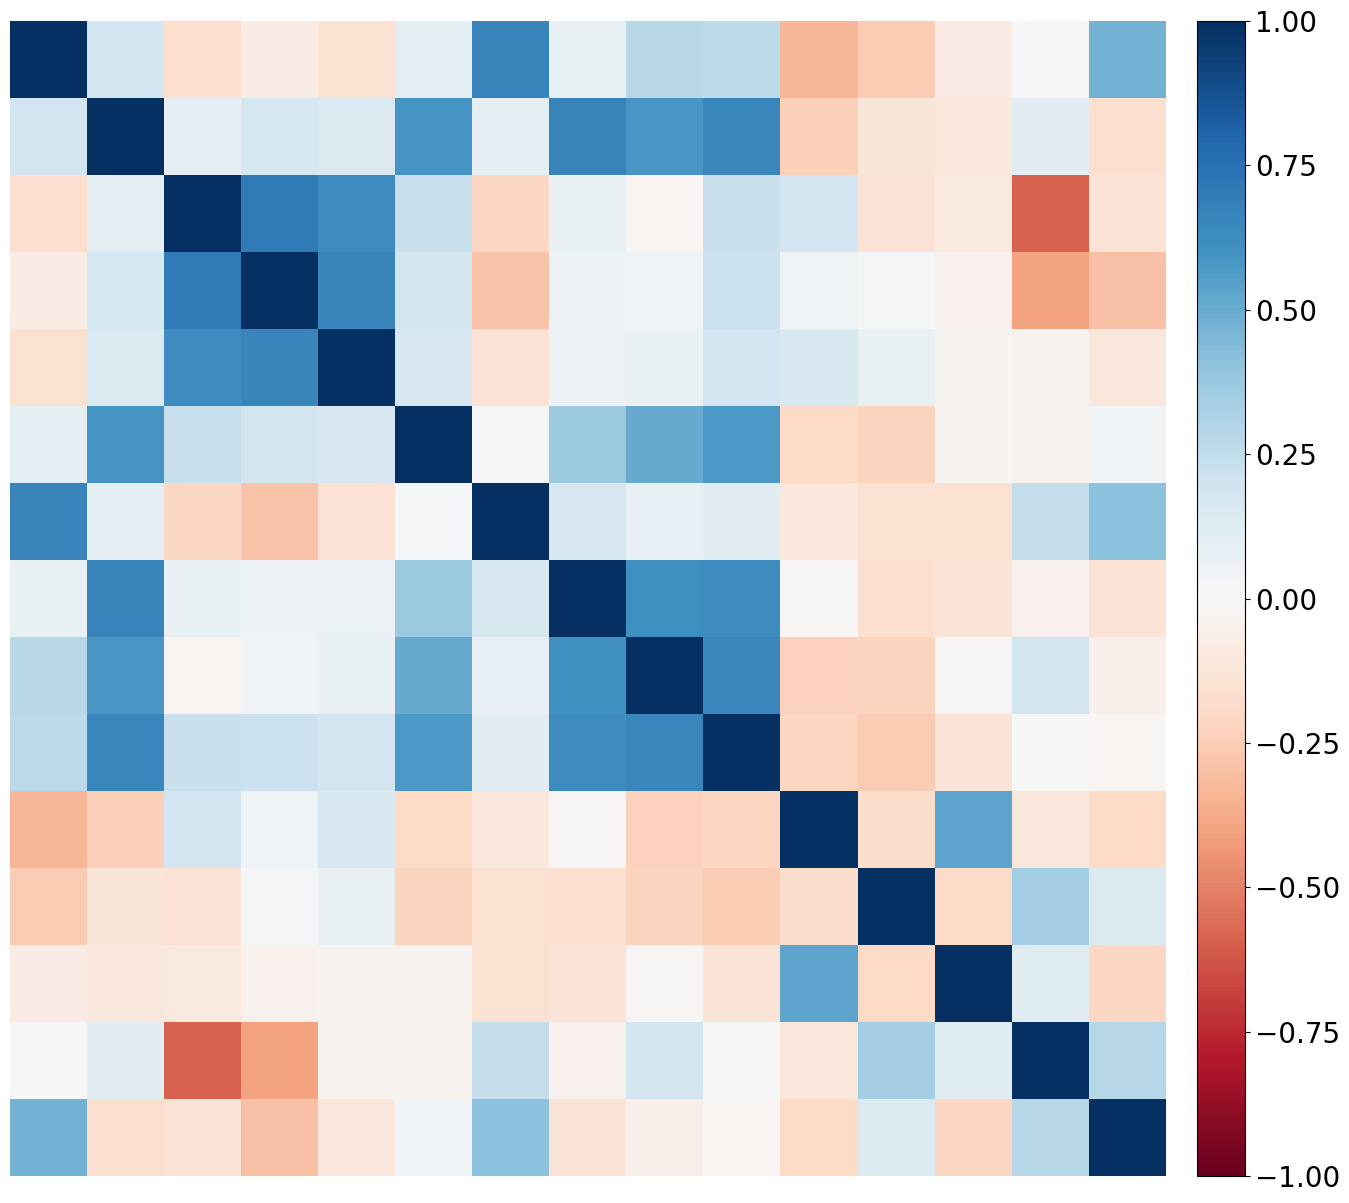

In [48]:
trainer.plot_similarity('type_similarity_sof')

In [63]:
out = model.learn(next(iter(data['train_loader'])))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [103]:
embeddings = torch.tensor([])
death = torch.tensor([])
trajectory_times = []
with torch.no_grad():
    for _, batch in enumerate(iter(data['train_loader'])):
        if _ == 1000:
            break
        emb = model.learn(batch).to('cpu')
        embeddings = torch.cat((embeddings, emb.mean(dim = 1)), dim=0)
        death = torch.cat((death, torch.tensor([int(15 in x) for x in batch.out_types])), dim=0) # 15 is the death type
        trajectory_times = trajectory_times +  batch.out_dts.cpu().numpy().tolist()

In [117]:
#find the first index that batch.out_types is 15 and then find the corresponding batch.out_dts
death_time = []
for i in range(len(death)):
    if death[i] == 1:
        death_time.append(sum(trajectory_times[i]))
    else:
        death_time.append(0)

In [119]:
death.shape  , len(death_time ), labels.shape 

(torch.Size([16000]), 16000, (16000,))

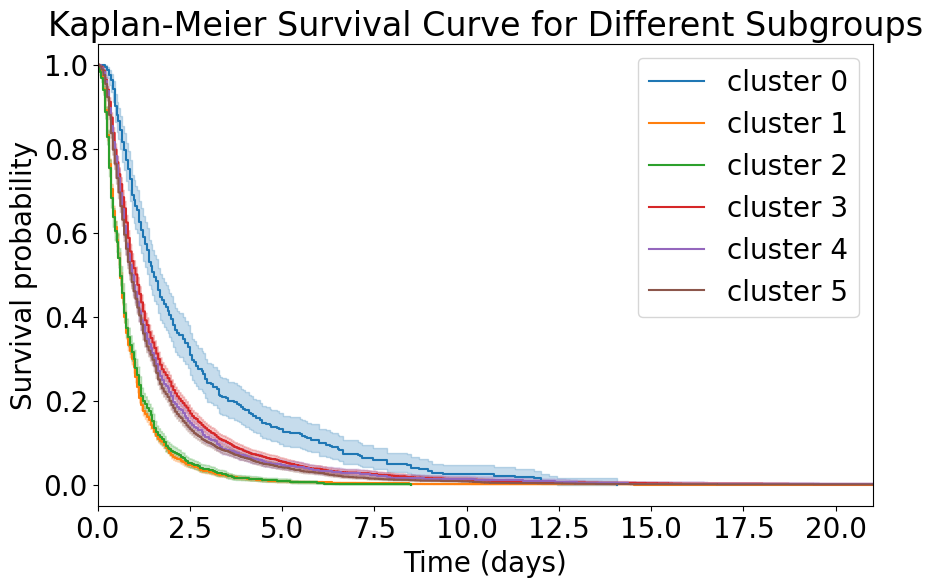

In [127]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for cluster in range(6):
    index = labels == cluster
    death_ = death[index]
    death_time_ = np.array(death_time)[index]
    kmf.fit(death_time_*3, event_observed=death_, label='cluster {}'.format(cluster))
    kmf.plot_survival_function()


plt.title('Kaplan-Meier Survival Curve for Different Subgroups')
plt.xlabel('Time (days)')
plt.xlim(0, 21)
plt.ylabel('Survival probability')
plt.show()



In [95]:
batch.out_dts[1, batch.out_types[1] == 15]

tensor([0., 0.], device='cuda:0')

In [71]:
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 6

# Initialize KMeans
kmeans = KMeans(n_clusters=n_clusters)

# Fit KMeans to your data
kmeans.fit(embeddings.numpy()[:,0,:])

# Get cluster assignments
labels = kmeans.labels_

c:\Users\mehak\Anaconda3\envs\trajectory\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


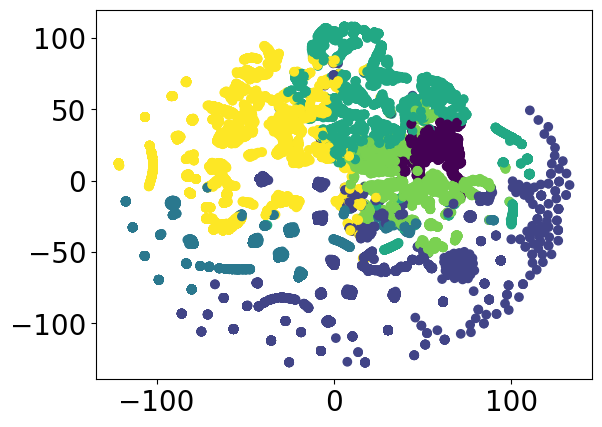

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define your data and labels
data_tsne = embeddings.numpy()[:,0,:]

# Initialize t-SNE
tsne = TSNE(n_components=2)

# Fit t-SNE to your data
embeddings_tsne = tsne.fit_transform(data_tsne)

# Plot embeddings
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels)
plt.show()

In [122]:
batch = next(iter(data['train_loader']))
out = model.learn(batch)
seq_dts, seq_types, seq_onehots = batch.out_dts, batch.out_types, batch.out_onehots
batch_size, seq_length, event_num, embed_size = out.shape
seq_dts = seq_dts.clamp(1e-8)
seq_dts_expand = prob_decoder.normalize_dt(seq_dts).unsqueeze(dim=-1).expand(-1, -1, event_num)

dts_hat, mean, log_var =  prob_decoder._forward(seq_dts_expand, out)

In [123]:
hidden = prob_decoder.encoder.mlp_transform(seq_dts_expand, out)
print(out.shape)

torch.Size([16, 121, 1, 32])


In [124]:
samples = prob_decoder.t_sample(out, 100) 

In [125]:
samples[0].shape, samples[1].shape

(torch.Size([16, 100, 121, 1]), torch.Size([16, 100, 121, 1]))

In [128]:
intervals = samples[0].mean(dim = 1)

In [150]:
generated_sequences = intervals[:, :, 0].detach().cpu().numpy()

In [175]:
real_sequences = batch.in_times.detach().cpu().numpy()

In [174]:
print(dir(batch))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'in_dts', 'in_times', 'in_types', 'lag_matrixes', 'out_dts', 'out_onehots', 'out_types', 'seq_lengths']


In [176]:
real_sequences[0]

array([ 0.30147284,  0.3014763 ,  0.7973184 ,  1.6317604 ,  1.7549196 ,
        2.6143947 ,  2.770768  ,  3.0912664 ,  3.4925063 ,  3.6416974 ,
        3.682928  ,  3.720861  ,  3.7856805 ,  4.5547543 ,  4.9042416 ,
        5.0866594 ,  5.8928003 ,  7.6215305 ,  8.028015  ,  8.300039  ,
        9.274528  ,  9.328916  , 10.28409   , 10.376005  , 10.936162  ,
       10.941652  , 10.941668  , 10.941746  , 10.941749  , 11.138063  ,
       11.269396  , 12.164178  , 12.220229  , 12.815565  , 14.2750845 ,
       14.2860155 , 14.592311  , 14.954294  , 15.634547  , 15.64309   ,
       15.718935  , 16.513025  , 16.58689   , 16.693298  , 16.990204  ,
       17.834305  , 17.91652   , 18.553324  , 18.570187  , 18.93217   ,
       19.056644  , 19.459595  , 19.718739  , 20.714708  , 21.318634  ,
       21.410807  , 21.666674  , 21.78072   , 21.85886   , 22.06939   ,
       22.178482  , 23.043005  , 23.342592  , 23.534801  , 23.841528  ,
       24.035168  , 24.653255  , 24.815256  , 25.615421  , 25.90

In [177]:
#add interval times to get arrival times
generated_sequences = np.cumsum(generated_sequences, axis = 1)

In [178]:
generated_sequences[0]

array([ 0.76471585,  1.182035  ,  2.0758903 ,  2.7209065 ,  3.2558124 ,
        3.8108654 ,  4.438519  ,  4.8920283 ,  5.323143  ,  5.741874  ,
        6.138444  ,  6.441022  ,  6.7513    ,  7.093484  ,  7.4444494 ,
        7.816421  ,  8.158251  ,  8.528205  ,  8.885778  ,  9.243824  ,
        9.651158  , 10.043038  , 10.380187  , 10.701466  , 10.998788  ,
       11.089825  , 11.285864  , 11.445979  , 11.828134  , 12.228189  ,
       12.533886  , 12.956582  , 13.352853  , 13.7349825 , 14.056024  ,
       14.414452  , 14.729512  , 15.075154  , 15.384434  , 15.708697  ,
       16.032486  , 16.331831  , 16.636778  , 16.963696  , 17.241428  ,
       17.571842  , 17.948872  , 18.260614  , 18.593966  , 18.89188   ,
       19.160051  , 19.42346   , 19.710741  , 20.021133  , 20.290134  ,
       20.611872  , 20.894938  , 21.20474   , 21.538885  , 21.837584  ,
       22.099354  , 22.375208  , 22.674929  , 22.984217  , 23.248686  ,
       23.531956  , 23.848988  , 24.163992  , 24.474304  , 24.77

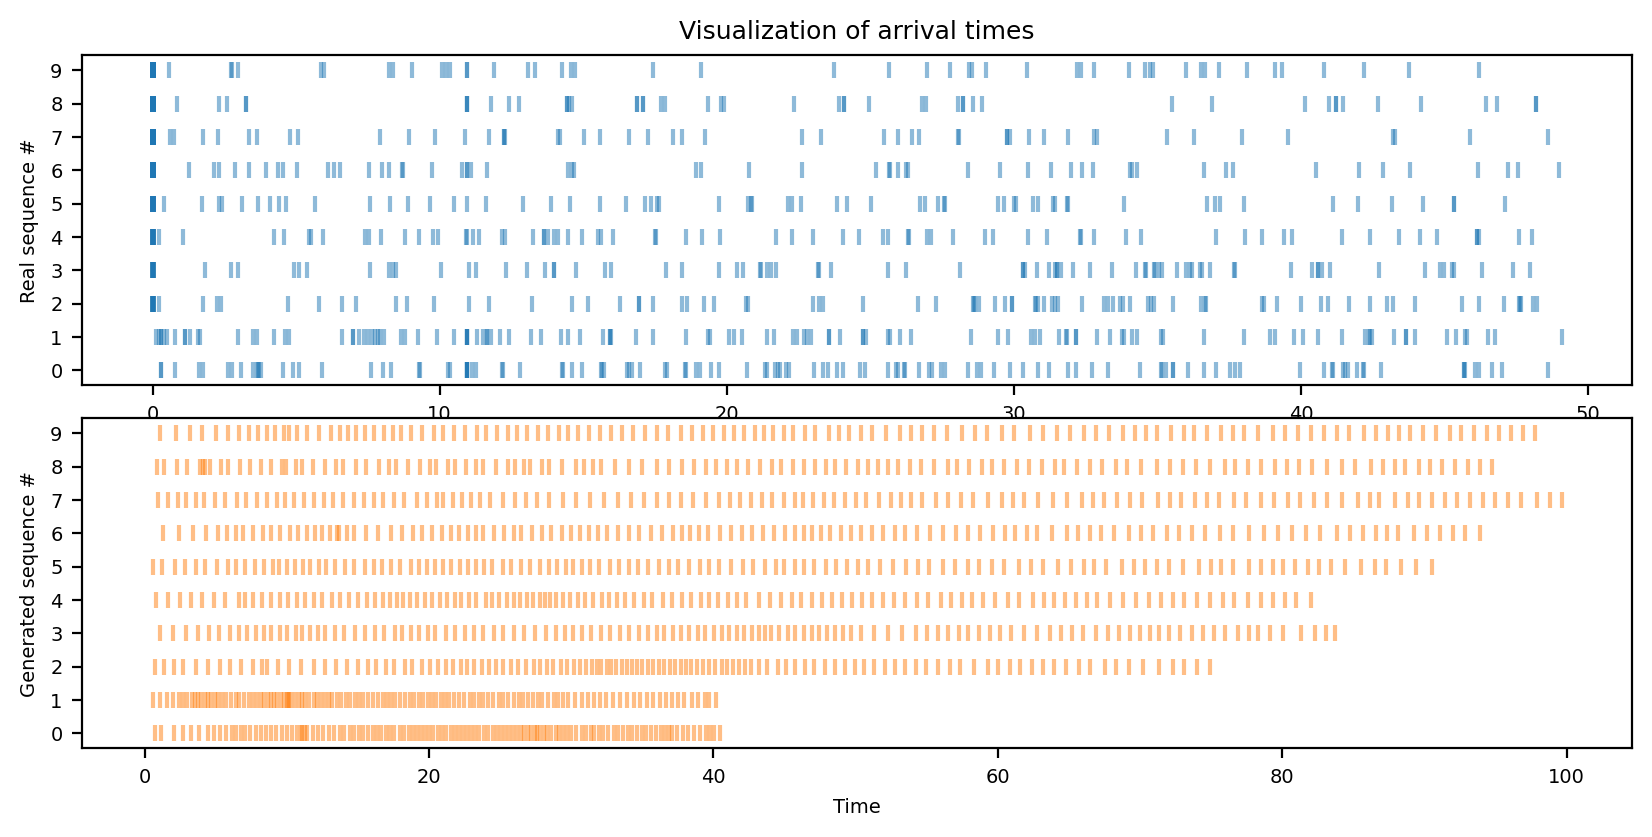

In [179]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=[10, 4.5], dpi=200, nrows=2, ncols= 1)
plt.subplots_adjust(hspace=0.1)
for idx, t in enumerate(real_sequences[:10]):
    axes[0].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C0', marker="|")
axes[0].set_ylabel("Real sequence #", fontsize=7)
axes[0].set_yticks(np.arange(10));
axes[0].set_title("Visualization of arrival times", fontsize=9)


for idx, t in enumerate(generated_sequences[:10]):
    axes[1].scatter(t, np.ones_like(t) * idx, alpha=0.5, c='C1', marker="|")
axes[1].set_xlabel("Time", fontsize=7)
axes[1].set_ylabel("Generated sequence #", fontsize=7)
axes[1].set_yticks(np.arange(10))
#axes[1].set_xticklabels([])

for ax in np.ravel(axes):
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)